In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn import preprocessing
plt.rc("font", size=14)

from scipy.stats import pearsonr

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from skimage.morphology import skeletonize,square,dilation 
from PVBM.GeometricalAnalysis import GeometricalVBMs
from PIL import Image,ImageFilter
from glob import glob

from itertools import combinations

# Data

In [3]:
data_a = pd.read_csv('morphological_data/morph_stats_aria.csv', index_col=0)
data_h = pd.read_csv('morphological_data/morph_stats_hrf.csv', index_col=0)
data_f = pd.read_csv('morphological_data/morph_stats_fives.csv', index_col=0)
data = pd.concat([data_a, data_h, data_f], axis=0, ignore_index=True)
data = data.drop('image_name', axis=1)
data = data.drop('prob_0', axis=1)
data = data.drop('prob_1', axis=1)
data = data.drop('pred_status', axis=1)
col_names = data.columns.values.tolist()[1:]
col_names.append(data.columns.values.tolist()[0])
data = data[col_names]
data = data.reindex(columns=col_names)
data

,status,area,endpoints,intersection_points,median_tortuosity,tortuosity_index,length,perimeter,BA_mean,BA_std,BA_median,D0,D1,D2,SL,group
0,0.0,8.689461,139.0,229.0,1.078279,1.099219,106.632566,234.974760,100.459093,49.387186,99.011606,1.517994,1.498753,1.489280,0.853023,test
1,0.0,9.115413,319.0,321.0,1.078517,1.107091,115.472692,263.997329,81.449024,58.081470,82.228490,1.557956,1.540376,1.521362,0.452518,test
2,0.0,8.304154,142.0,242.0,1.076243,1.083650,109.770908,239.680239,105.897363,50.668990,97.696052,1.515191,1.506909,1.497353,0.562682,test
3,0.0,10.072177,217.0,299.0,1.075317,1.081964,128.303866,282.075113,88.756358,58.389418,82.614248,1.569262,1.563687,1.548196,0.474867,test
4,0.0,7.540314,315.0,229.0,1.077154,1.087469,106.471108,242.227318,99.128903,52.245831,106.523867,1.541980,1.518671,1.496303,0.492801,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,1.0,4.450738,42.0,178.0,1.081538,1.104377,70.300491,150.808239,89.649757,47.985009,85.301319,1.375119,1.363198,1.357631,0.794079,val
537,1.0,8.081321,59.0,294.0,1.077640,1.084778,111.405455,231.738317,101.542611,44.320917,103.358515,1.452822,1.436105,1.422807,0.772668,val
538,1.0,8.188334,53.0,195.0,1.079669,1.093246,98.368303,205.623938,101.959127,39.609887,99.462669,1.438973,1.430844,1.417969,0.576936,val
539,1.0,8.322359,93.0,347.0,1.073153,1.085767,124.495572,260.194393,82.640303,49.280955,86.423666,1.483453,1.463672,1.448423,0.800174,val


# Plots

## Histograms

In [24]:
for name in col_names[1:-1]:

    plt.title(name)
    data.loc[data['status'] == 0, name].plot.kde(label='control')
    data.loc[data['status'] == 1, name].plot.kde(label='retina')
    plt.legend()
    plt.savefig('morphological_data/hist_plots/by_status/'+name+'_stat_dens.jpg')
    plt.close()

for name in col_names[:-1]:
    plt.title(name)
    data[name].plot.hist()
    plt.savefig('morphological_data/hist_plots/general/'+name+'_hist.jpg')
    plt.close()

## Correlation plots

In [28]:
pairs = sorted(map(sorted, combinations(set(col_names[1:-1]), 2)))

for pair in pairs:
    sn.regplot(data[data['status'] == 0] , x=pair[0],y=pair[1], color='blue', label='control')
    sn.regplot(data[data['status'] == 1] , x=pair[0],y=pair[1], color='red' , label='retina')
    r_cont, _ = pearsonr(data.loc[data['status'] == 0, pair[0]], data.loc[data['status'] == 0, pair[1]])
    r_ret, _ = pearsonr(data.loc[data['status'] == 1, pair[0]], data.loc[data['status'] == 1, pair[1]])
    plt.title(f'corr_control: {r_cont:.2f}  corr_retina: {r_ret:.2f}')
    plt.legend()
    plt.savefig('morphological_data/corr_plots/by_status/'+pair[1]+'_x_'+pair[0]+'.jpg')
    plt.close()
    # sn.regplot(data[data['pred_status'] == 0] , x=pair[0],y=pair[1], color='blue', label='control')
    # sn.regplot(data[data['pred_status'] == 1] , x=pair[0],y=pair[1], color='red' , label='retina')
    # r_cont, _ = pearsonr(data.loc[data['pred_status'] == 0, pair[0]], data.loc[data['pred_status'] == 0, pair[1]])
    # r_ret, _ = pearsonr(data.loc[data['pred_status'] == 1, pair[0]], data.loc[data['pred_status'] == 1, pair[1]])
    # plt.title(f'corr_control: {r_cont:.2f}  corr_retina: {r_ret:.2f}')
    # plt.legend()
    # plt.savefig('morphological_data/corr_plots/by_pred_status/'+pair[1]+'_x_'+pair[0]+'.jpg')
    # plt.close()

## Arc lenght histograms

In [36]:
paths_list = glob('data/data_m_vessel/test/control/*') + glob('data/data_m_vessel/test/retina/*')

fives, aria, hrf = [], [], []
con, ret = [], []

for i, path in enumerate(paths_list):

    index = i+1
    
    name = path.split('\\')[-1]
    stat = path.split('\\')[0].split('/')[-1]
    if name.split('.')[-1] == 'png':
        pixel_size = 4/786
        dataset = 'FIVES'
    else:
        if name[0] == 'a':
            pixel_size = 4/243
            dataset = 'ARIA'
        else:
            pixel_size = 4/940
            dataset = 'HRF'

    segmentation = Image.open(path)
    segmentation = segmentation.filter(ImageFilter.ModeFilter(size=3))
    segmentation = np.array(segmentation)/255
    if len(segmentation.shape) == 3 : segmentation = segmentation[:,:,0]
    skeleton = skeletonize(segmentation) 

    median_tor, length, chord, arc, _ = GeometricalVBMs().compute_tortuosity_length(skeleton)
    arc = (np.array(arc) * pixel_size).tolist()

    if dataset == 'FIVES': fives += arc
    elif dataset == 'ARIA': aria += arc
    else: hrf += arc
    if stat == 'control': con += arc
    else: ret += arc

    plt.hist(arc)
    plt.title(dataset+': '+name)
    plt.savefig('morphological_data/arc_lenght_plots_for_img/plots/'+dataset+'_'+name.split('.')[0]+'.jpg')
    plt.close()

plt.title('FIVES')
plt.hist(fives, density=True)
plt.savefig('morphological_data/arc_lenght_plots_for_img/FIVES_arc_len_hist.jpg')
plt.close()
plt.title('ARIA')
plt.hist(aria, density=True)
plt.savefig('morphological_data/arc_lenght_plots_for_img/ARIA_arc_len_hist.jpg')
plt.close()
plt.title('HRF')
plt.hist(hrf, density=True)
plt.savefig('morphological_data/arc_lenght_plots_for_img/HRF_arc_len_hist.jpg')
plt.close()

plt.title('arc lenght for datasets')
sn.kdeplot(fives, color='red', fill=True, alpha=.3, linewidth=0, label='FIVES')
sn.kdeplot(aria, color='blue', fill=True, alpha=.3, linewidth=0, label='ARIA')
sn.kdeplot(hrf, color='green', fill=True, alpha=.3, linewidth=0, label='HRF')
plt.legend()
plt.savefig('morphological_data/arc_lenght_plots_for_img/arc_len_data_dens.jpg')
plt.close()

plt.title('arc lenght for groups')
sn.kdeplot(con, color='blue', fill=True, alpha=.3, linewidth=0, label='control')
sn.kdeplot(ret, color='red', fill=True, alpha=.3, linewidth=0, label='retina')
plt.legend()
plt.savefig('morphological_data/arc_lenght_plots_for_img/arc_len_groups_dens.jpg')
plt.close()


## Mosaic plot

In [37]:
def corrfunc(x, y, **kws):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
def my_hist(x, label, color):
    ax0 = plt.gca()
    ax = ax0.twinx()
    
    sn.despine(ax=ax, left=True, top=True, right=False)
    ax.yaxis.tick_right()
    ax.set_ylabel('Counts')
    
    ax.hist(x, label=label, color=color)
    
sn.set(style="ticks", color_codes=True)
# iris = sn.load_dataset('iris')
g = sn.pairplot(data, kind="reg", plot_kws={'line_kws':{'color':'red'}})

for ax in g.axes.flat:
  ax.tick_params(axis='both', labelleft=True, labelbottom=True)

plt.subplots_adjust(wspace=0.7, hspace=0.3)

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
  xlabel = ax.xaxis.get_label_text()
  xlabels.append(xlabel)
for ax in g.axes[:,0]:
  ylabel = ax.yaxis.get_label_text()
  ylabels.append(ylabel)

for i in range(len(xlabels)):
  for j in range(len(ylabels)):
    if i == j:
      g.axes[j,i].yaxis.set_visible(False)
      g.axes[j,i].xaxis.set_label_text(xlabels[i], visible=True)
      sn.despine(ax=g.axes[j,i], left=True, top=True, right=False)
    else:
      g.axes[j,i].xaxis.set_label_text(xlabels[i], visible=True)
      g.axes[j,i].yaxis.set_label_text(ylabels[j], visible=True)

g.map_upper(hide_current_axis)
g.map_diag(hide_current_axis)
g.map_lower(corrfunc)
g.map_diag(my_hist)

plt.savefig('morphological_data/pairgrid.jpg')
plt.close()

# Analysis

## Correlation Matrix

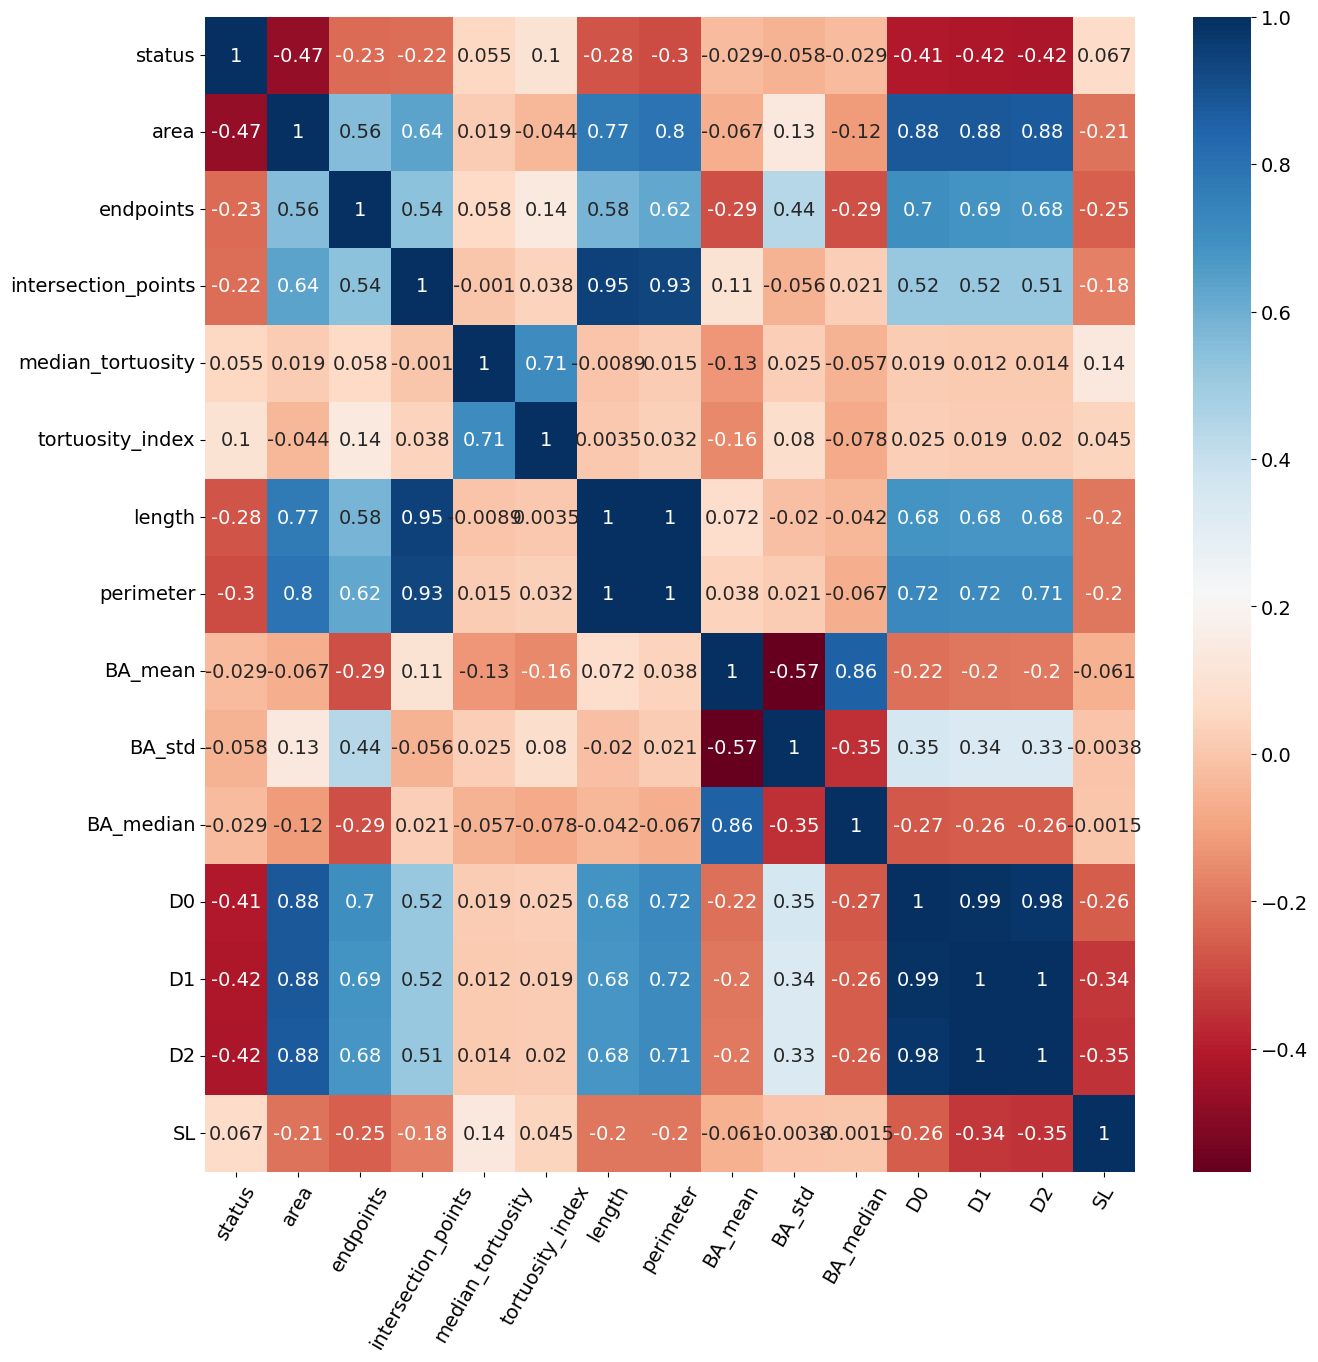

In [35]:
corr_matrix = data[col_names[:-1]].corr()
plt.figure(figsize=(15,15))
sn.heatmap(corr_matrix, annot=True, cmap='RdBu')
plt.xticks(rotation = 60) 
plt.show()

## Logistic Regression

In [21]:
data_train = data[data['group'] == 'train']
data_test = data[data['group'] == 'test']

X_train, y_train, X_test, y_test = data_train.iloc[:, 1:-1].values, data_train.iloc[:, 0].values, data_test.iloc[:, 1:-1].values, data_test.iloc[:, 0].values

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

model = LogisticRegression()

model.fit(X_train_std, y_train)

y_train_pred = model.predict(X_train_std)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_train, y_train_pred)
matthews_cor = matthews_corrcoef(y_train, y_train_pred)

print('Training\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)

y_test_pred = model.predict(X_test_std)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_test, y_test_pred)
matthews_cor = matthews_corrcoef(y_test, y_test_pred)

print('Test\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)

sfs1 = SFS(model, 
           k_features="best",
           forward=False, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=10)


sfs1 = sfs1.fit(X_train_std, y_train)

print('selected features:\n', list(data.columns[1:-1][list(sfs1.k_feature_idx_)]))

X_train_sele = sfs1.transform(X_train_std)
X_test_sele = sfs1.transform(X_test_std)

model.fit(X_train_sele, y_train)

y_train_pred = model.predict(X_train_sele)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_train, y_train_pred)
matthews_cor = matthews_corrcoef(y_train, y_train_pred)

print('Training\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)

y_test_pred = model.predict(X_test_sele)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_test, y_test_pred)
matthews_cor = matthews_corrcoef(y_test, y_test_pred)

print('Test\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)


Training
accuracy:  0.800531914893617 
recall 0.7282608695652174 
precision 0.8427672955974843 
specificity 0.8697916666666666 
f1_score 0.7813411078717201 
matthews_cor 0.6051603052329423
Test
accuracy:  0.8727272727272727 
recall 0.8148148148148148 
precision 0.9166666666666666 
specificity 0.9285714285714286 
f1_score 0.8627450980392156 
matthews_cor 0.7493573131510374
selected features:
 ['area', 'endpoints', 'intersection_points', 'tortuosity_index', 'length', 'BA_mean', 'D1']
Training
accuracy:  0.7952127659574468 
recall 0.7228260869565217 
precision 0.8364779874213837 
specificity 0.8645833333333334 
f1_score 0.7755102040816327 
matthews_cor 0.594390697377604
Test
accuracy:  0.8181818181818182 
recall 0.7777777777777778 
precision 0.84 
specificity 0.8571428571428571 
f1_score 0.8076923076923077 
matthews_cor 0.6374552583116766


In [22]:
pd.DataFrame(zip(list(data.columns[1:-1][list(sfs1.k_feature_idx_)]), model.coef_[0]))

,0,1
0,area,-1.520171
1,endpoints,0.051988
2,intersection_points,-0.438623
3,tortuosity_index,0.161614
4,length,1.117683
5,BA_mean,-0.217412
6,D1,-0.733997


## K Neighbors Classifier

In [8]:
data_train = data[data['group'] == 'train']
data_test = data[data['group'] == 'test']

X_train, y_train, X_test, y_test = data_train.iloc[:, 1:-1].values, data_train.iloc[:, 0].values, data_test.iloc[:, 1:-1].values, data_test.iloc[:, 0].values

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train_std, y_train)

y_train_pred = model.predict(X_train_std)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_train, y_train_pred)
matthews_cor = matthews_corrcoef(y_train, y_train_pred)

print('Training\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)

y_test_pred = model.predict(X_test_std)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_test, y_test_pred)
matthews_cor = matthews_corrcoef(y_test, y_test_pred)

print('Test\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)

sfs1 = SFS(model, 
           k_features="best",
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)


sfs1 = sfs1.fit(X_train_std, y_train)

print('selected features:\n', list(data.columns[1:-1][list(sfs1.k_feature_idx_)]))

X_train_sele = sfs1.transform(X_train_std)
X_test_sele = sfs1.transform(X_test_std)

model.fit(X_train_sele, y_train)

y_train_pred = model.predict(X_train_sele)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_train, y_train_pred)
matthews_cor = matthews_corrcoef(y_train, y_train_pred)

print('Training\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)

y_test_pred = model.predict(X_test_sele)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_test, y_test_pred)
matthews_cor = matthews_corrcoef(y_test, y_test_pred)

print('Test\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)

Training
accuracy:  0.8191489361702128 
recall 0.7608695652173914 
precision 0.8536585365853658 
specificity 0.875 
f1_score 0.8045977011494252 
matthews_cor 0.640970010119527
Test
accuracy:  0.7818181818181819 
recall 0.6666666666666666 
precision 0.8571428571428571 
specificity 0.8928571428571429 
f1_score 0.75 
matthews_cor 0.5757452501212796
selected features:
 ['area', 'endpoints', 'intersection_points', 'length', 'perimeter', 'BA_median']
Training
accuracy:  0.8404255319148937 
recall 0.7771739130434783 
precision 0.8827160493827161 
specificity 0.9010416666666666 
f1_score 0.8265895953757224 
matthews_cor 0.6846409849221109
Test
accuracy:  0.8181818181818182 
recall 0.8148148148148148 
precision 0.8148148148148148 
specificity 0.8214285714285714 
f1_score 0.8148148148148148 
matthews_cor 0.6362433862433863


## Random Forest

Training
accuracy:  0.9202127659574468 
recall 0.8586956521739131 
precision 0.9753086419753086 
specificity 0.9791666666666666 
f1_score 0.9132947976878614 
matthews_cor 0.8458002150957631
Test
accuracy:  0.8545454545454545 
recall 0.8148148148148148 
precision 0.88 
specificity 0.8928571428571429 
f1_score 0.8461538461538461 
matthews_cor 0.7104970066598896


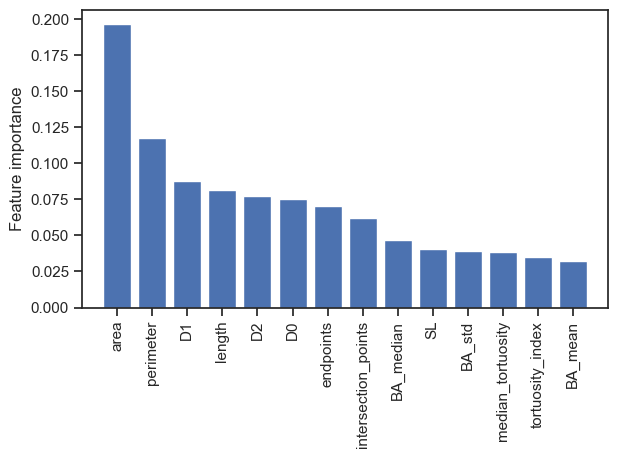

In [90]:
data_train = data[data['group'] == 'train']
data_test = data[data['group'] == 'test']

X_train, y_train, X_test, y_test = data_train.iloc[:, 1:-1].values, data_train.iloc[:, 0].values, data_test.iloc[:, 1:-1].values, data_test.iloc[:, 0].values

forest = RandomForestClassifier(n_estimators=1000, max_depth=6, #max_features=1, 
                                random_state=1)

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_train, y_train_pred)
matthews_cor = matthews_corrcoef(y_train, y_train_pred)

print('Training\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)

y_test_pred = forest.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
accuracy = (tp+tn)/(tn+fp+fn+tp)
recall = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(fp+tn)
f1_sc = f1_score(y_test, y_test_pred)
matthews_cor = matthews_corrcoef(y_test, y_test_pred)

print('Test\naccuracy: ', accuracy, '\nrecall', recall, '\nprecision', precision, '\nspecificity', specificity, '\nf1_score', f1_sc, '\nmatthews_cor', matthews_cor)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = data.columns[1:-1]
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.show()

In [23]:
# from sklearn import tree 
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
# tree.plot_tree(forest.estimators_[0],
#                feature_names = feat_labels, 
#                class_names=['control', 'diabetic'],
#                impurity=False)